<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Setup Load Data & Optimize Memory

from google.colab import drive
import pandas as pd
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


# Define Memory Reduction Function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# 2. Mount Drive
drive.mount('/content/drive')

# 3. Load Data
file_path = '/content/drive/My Drive/instacart_train_data.pkl'
print(f"Loading data from {file_path}...")
data_train = pd.read_pickle(file_path)

# 4. Optimize Immediately
data_train = reduce_mem_usage(data_train)

# 5. Quick Check
print("Data Loaded & Optimized Successfully.")
print(data_train.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Memory usage of dataframe is 1212.31 MB


/tmp/ipython-input-3831436621.py:37: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:


Memory usage after optimization is: 662.73 MB
Decreased by 45.3%
Data Loaded & Optimized Successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 8474661 entries, 0 to 13307952
Data columns (total 36 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   user_id                       int32   
 1   product_id                    int32   
 2   uxp_total_bought              int8    
 3   uxp_days_since_last_purchase  float16 
 4   uxp_reorder_rate              float16 
 5   uxp_first_order_number        int8    
 6   order_id                      int32   
 7   eval_set                      category
 8   days_since_prior_order        float16 
 9   user_total_orders             int8    
 10  user_avg_days_between_orders  float16 
 11  user_total_items              int16   
 12  user_reorder_ratio            float16 
 13  user_avg_basket_size          float16 
 14  user_last_order_days          float16 
 15  orders                        int32

In [2]:
#  Train/Test Split

# Define Features (X) and Target (y)
# Adjust the drop list if you have other non-feature columns
features_to_drop = ['reordered', 'eval_set', 'user_id', 'product_id', 'order_id']
X = data_train.drop([c for c in features_to_drop if c in data_train.columns], axis=1)
y = data_train['reordered']
groups = data_train['user_id']

# Split 80% Train, 20% Test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Clean up memory
del data_train
gc.collect()

Train shape: (6777721, 31), Test shape: (1696940, 31)


90

Training XGBoost model...

Evaluating model
XGBoost AUC: 0.8237


<Figure size 1000x800 with 0 Axes>

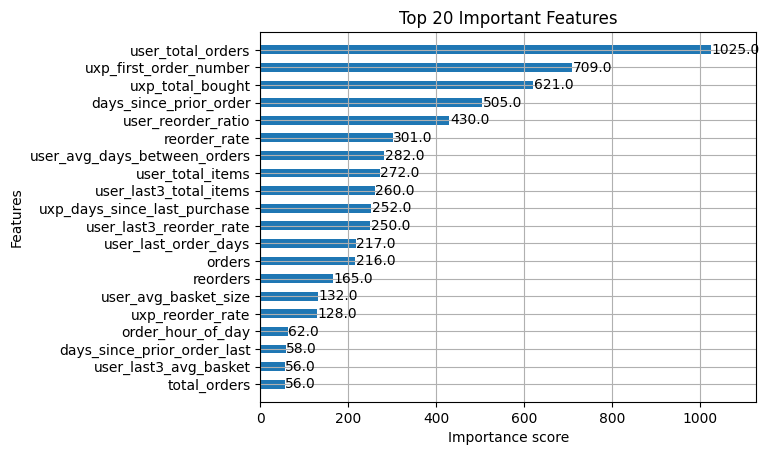

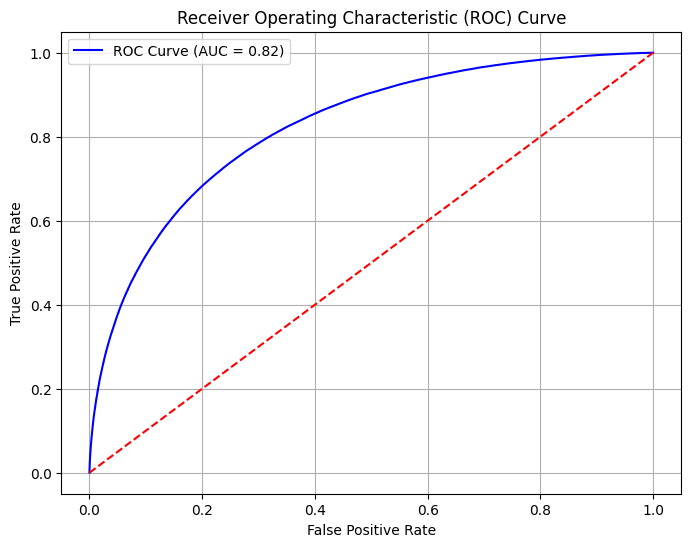

In [3]:
# XGBoost Model Training

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    device='cpu',
    enable_categorical=True
    )

# Fit the model on the training split
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

#Evaluating

print("\nEvaluating model")
preds_prob = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, preds_prob)
print(f"XGBoost AUC: {auc_score:.4f}")

# --- FIGURES ---

#  Feature Importance
# This shows which columns had the biggest impact on the decision
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20, height=0.5, importance_type='weight', title='Top 20 Important Features')
plt.show()

# ROC Curve
# This shows the trade-off between True Positives and False Positives
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonal line (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

Tuning on 1355544 rows to save memory...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Params: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'enable_categorical': True}
Best Score: 0.8229


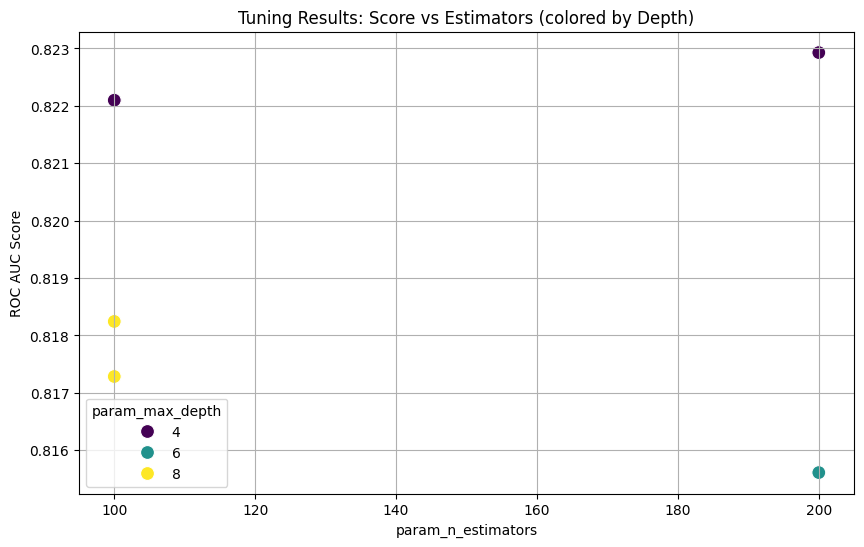

10121

In [4]:


# Tune on a smaller sample to save RAM
# We use 20% of data for finding params. This prevents OOM crashes.
sample_size = int(len(X_train) * 0.2)
X_tune = X_train.iloc[:sample_size]
y_tune = y_train.iloc[:sample_size]

print(f"Tuning on {sample_size} rows to save memory...")

#  Define Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9],
    # ensure we handle categories if using them
    'enable_categorical': [True]
}

# Setup Search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        device='cpu'
    ),
    param_distributions=param_grid,
    n_iter=5,          # Keep low for speed/memory
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=1           #prevents duplicating data in RAM
)

#  Run Search
random_search.fit(X_tune, y_tune)

print(f"Best Params: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_:.4f}")

# --- FIGURES ---
# Extract results for plotting
results_df = pd.DataFrame(random_search.cv_results_)

# Hyperparameter Performance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', s=100, palette='viridis')
plt.title('Tuning Results: Score vs Estimators (colored by Depth)')
plt.ylabel('ROC AUC Score')
plt.grid(True)
plt.show()

# Cleanup
del X_tune, y_tune, results_df
gc.collect()

In [5]:
!pip install h2o
import h2o


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,53 mins 02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_unknownUser_yu6ayd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.979 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Saving training data to disk to save RAM...
Deleting Pandas objects from RAM...
Loading data into H2O from disk...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Starting AutoML...
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

--- Leaderboard ---
model_id                                 auc    logloss     aucpr    mean_per_class_error      rmse        mse
XGBoost_1_AutoML_1_20260102_191242  0.814902   0.296814  0.383869                0.304099  0.282848  0.0800032
[1 row x 7 columns]



/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/tmp/ipython-input-540533124.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='auc', y='model_id', data=lb_df.head(5), palette='magma')


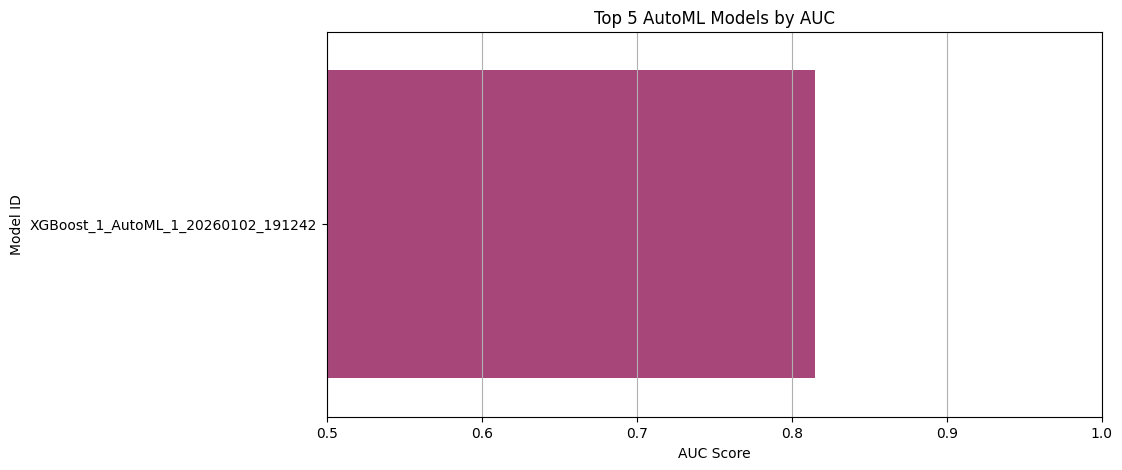


Plotting Variable Importance...


/tmp/ipython-input-540533124.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='scaled_importance', y='variable', data=varimp.head(15), palette='viridis')


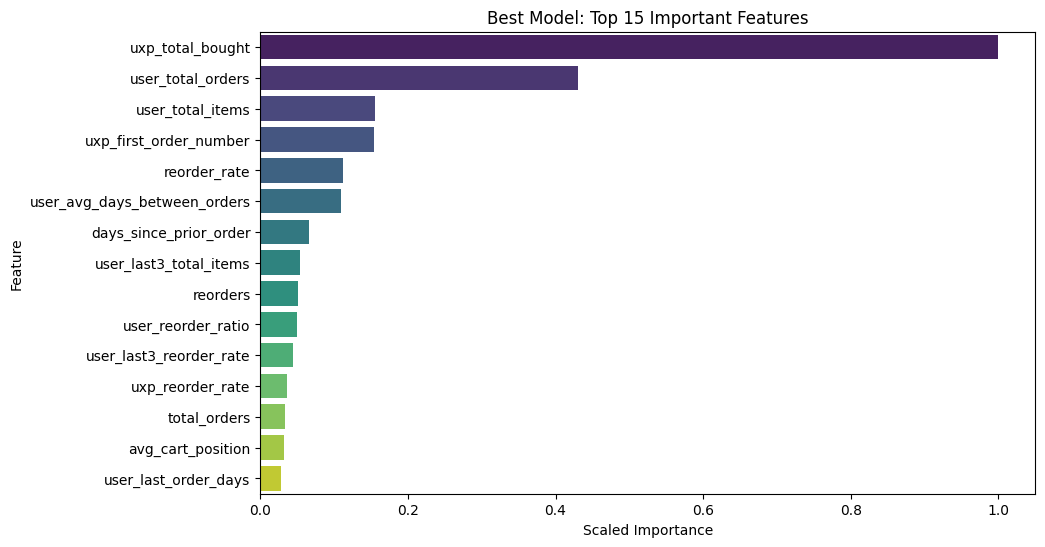

In [6]:
#  H2O AutoML


from h2o.automl import H2OAutoML
import pandas as pd
import gc
import os


# We restrict memory usage carefully
h2o.init(max_mem_size='4G')

#  SAVE TO DISK
# Instead of converting in RAM, we save to CSV and let H2O read the file.
print("Saving training data to disk to save RAM...")
temp_path = 'temp_train_data.csv'

# Combine X and y temporarily just to save the file
train_temp = pd.concat([X_train, y_train], axis=1)
train_temp.to_csv(temp_path, index=False)

#  DELETE PANDAS OBJECTS IMMEDIATELY
print("Deleting Pandas objects from RAM...")
del train_temp
gc.collect()

#  Load into H2O directly from Disk
print("Loading data into H2O from disk...")
hf = h2o.import_file(path=temp_path)

# Define columns
y_col = 'reordered'
x_cols = [c for c in hf.columns if c != y_col]

# Ensure target is a factor
hf[y_col] = hf[y_col].asfactor()

#  Run AutoML
print("Starting AutoML...")
aml = H2OAutoML(max_models=3, seed=1, max_runtime_secs=180, project_name="Instacart_AutoML")
aml.train(x=x_cols, y=y_col, training_frame=hf)

# Leaderboard
print("\n--- Leaderboard ---")
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))


# --- FIGURES ---

#  Model Performance Leaderboard
lb_df = lb.as_data_frame()
plt.figure(figsize=(10, 5))
sns.barplot(x='auc', y='model_id', data=lb_df.head(5), palette='magma')
plt.title('Top 5 AutoML Models by AUC')
plt.xlabel('AUC Score')
plt.ylabel('Model ID')
plt.xlim(0.5, 1.0)
plt.grid(axis='x')
plt.show()

# Variable Importance (Best Model)
print("\nPlotting Variable Importance...")
best_model = aml.leader
try:
    # Get importance and plot
    varimp = best_model.varimp(use_pandas=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='scaled_importance', y='variable', data=varimp.head(15), palette='viridis')
    plt.title('Best Model: Top 15 Important Features')
    plt.xlabel('Scaled Importance')
    plt.ylabel('Feature')
    plt.show()
except:
    print("Variable importance plot not available for this specific model type (e.g., Stacked Ensembles often don't support it).")

# Cleanup the temporary file
if os.path.exists(temp_path):
    os.remove(temp_path)





# Cleanup the temporary file
if os.path.exists(temp_path):
    os.remove(temp_path)



